### Importing the data from drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/Deep\ Learning\ Project

/content/drive/MyDrive/Deep Learning Project


In [36]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import Model
from tensorflow.keras.applications.resnet50 import ResNet50
import cv2
from keras.preprocessing import image
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import matplotlib.pyplot as plt
from keras.layers import GlobalMaxPooling2D
import warnings
import pickle
warnings.filterwarnings('ignore')
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import DenseNet121
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn import preprocessing
import random
import pickle

In [4]:
with open('images.npy', 'rb') as f:
  images = np.load(f)

In [7]:
img_info_df = pd.read_csv("train_data.csv", index_col=0).reset_index()

In [35]:
img_info_df

index  ... Image Category
0          0  ...          Skirt
1          1  ...          Dress
2          2  ...          Jeans
3          3  ...         Blazer
4          4  ...          Dress
...      ...  ...            ...
13994  13994  ...         Romper
13995  13995  ...          Dress
13996  13996  ...           Tank
13997  13997  ...           Coat
13998  13998  ...          Dress

[13999 rows x 29 columns]

### Category Wise Data

In [9]:
category_sum = img_info_df.groupby(['Image Category'], sort=True).size().reset_index(name='Count')
print("Total image categories:", len(category_sum))
category_sum.sort_values(by = 'Count', ascending=False)

Total image categories: 45


Image Category  Count
13          Dress   4016
41            Tee   1621
2          Blouse   1054
35         Shorts    822
40           Tank    726
36          Skirt    680
7        Cardigan    635
37        Sweater    557
42            Top    534
18         Jacket    476
1          Blazer    367
24       Jumpsuit    351
19          Jeans    344
33         Romper    340
27       Leggings    232
17         Hoodie    201
23        Joggers    200
26         Kimono    143
38     Sweatpants    116
9            Coat    115
12        Cutoffs     71
39    Sweatshorts     58
16         Henley     45
21         Jersey     40
31         Poncho     35
11       Culottes     34
20       Jeggings     29
8          Chinos     28
29          Parka     26
43         Trunks     17
3          Bomber     16
44     Turtleneck     11
0          Anorak      9
4     Button-Down      9
25         Kaftan      8
6          Capris      7
14        Flannel      6
28         Onesie      5
32           Robe      3
34         Sarong      3
22       Jodhpurs      3
30        Peacoat      2
10        Coverup      2
15         Halter      1
5          Caftan      1

### Creating a balanced train-test split 

In [10]:
def trainTestSplit(category_sum):
    categories = category_sum["Image Category"].tolist()
    trainData = pd.DataFrame()
    testData = pd.DataFrame()
    for i in range(len(category_sum)):
        count = category_sum.iloc[i]["Count"]
        category = category_sum.iloc[i]["Image Category"]
        data = img_info_df.loc[img_info_df["Image Category"]==category]
        trainCount = int(0.8*count)
        trainData = trainData.append(data.iloc[0:trainCount-1])
        testData = testData.append(data.iloc[trainCount:])
    return trainData, testData

In [11]:
trainData, testData = trainTestSplit(category_sum)
trainData = trainData.reset_index()
testData = testData.reset_index()

img/Striped_Crew_Neck_Tee/img_00000052.jpg


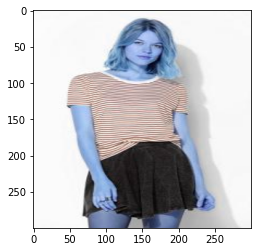

In [12]:
print(trainData.iloc[10000]['Image Paths'])
plt.imshow(images[trainData.iloc[10000]['index']])

### Deep Learning based existing models for feature extraction

In [13]:
def inceptionModel(height, width):
    model = InceptionV3(weights='imagenet', include_top=False, input_shape = (height, width, 3))
    model.trainable = False
    output = GlobalMaxPooling2D()(model.outputs)
    model = Model(inputs=model.inputs, outputs=output)
    #model.summary()
    return model
    
def mobileNet(height, width):
    model = MobileNet(weights='imagenet', include_top=False, input_shape = (height, width, 3))
    model.trainable = False
    output = GlobalMaxPooling2D()(model.outputs)
    model = Model(inputs=model.inputs, outputs=output)
    model.summary()
    return model

def resNet(height, width):
    model = ResNet50(weights='imagenet', include_top=False, input_shape = (height, width, 3))
    model.trainable = False
    output = GlobalMaxPooling2D()(model.outputs)
    model = Model(inputs=model.inputs, outputs=output)
    model.summary()
    return model

def vgg(height, width):
    model = VGG16(weights='imagenet', include_top=False, input_shape = (height, width, 3))
    model.trainable = False
    output = GlobalMaxPooling2D()(model.outputs)
    model = Model(inputs=model.inputs, outputs=output)
    model.summary()
    return model

def denseNet(height, width):
    model = DenseNet121(weights='imagenet', include_top=False, input_shape = (height, width, 3))
    model.trainable = False
    output = GlobalMaxPooling2D()(model.outputs)
    model = Model(inputs=model.inputs, outputs=output)
    model.summary()
    return model


def getFeatureVector(model, image):
    featureVector = model.predict(image)
    featureVector = featureVector.flatten()
    return featureVector

### Inception Model with Feature Extraction and Nearest Neighbors

img/Striped_Crew_Neck_Tee/img_00000052.jpg
87924736/87910968 [==============================] - 1s 0us/step
(1, 300, 300, 3)


(16384,)

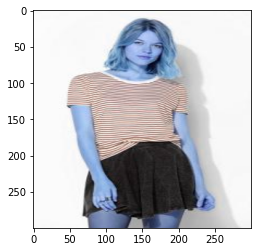

In [14]:
print(trainData.iloc[10000]['Image Paths'])
# plt.imshow(images[trainData.iloc[10000]['index']])

image = images[trainData.iloc[10000]['index']]
plt.imshow(image)
model = inceptionModel(image.shape[0], image.shape[1])
image =  np.expand_dims(image, axis = 0) 
print(image.shape)
featureVector = getFeatureVector(model, image)
featureVector.shape

In [16]:
def generateFeatures(model, data):
    labels = []
    features = []
    ids = []
    for index, row in data.iterrows():
        ids.append(index)
        image = images[data.iloc[index]['index']]
        image =  np.expand_dims(image, axis = 0) 
        label = row['Image Category']
        featureVector = getFeatureVector(model, image)
        features.append(featureVector)
        labels.append(label)

    return np.array(features), labels, ids

In [17]:
trainFeatures, trainLabels, trainIds = generateFeatures(model, trainData)
testFeatures, testLabels, testIds = generateFeatures(model, testData)

### Nearest neighbours without added features

In [18]:
from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=5, n_jobs=-1)
model_knn.fit(trainFeatures)
test_data_neighbors = model_knn.kneighbors(testFeatures)

### 5 Recommended Images for each 5 Random images for Inception

Original Image 9
Longline_Side-Slit_Blazer


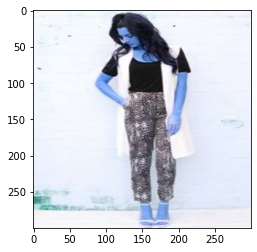

Floral_Print_Bodycon_Dress


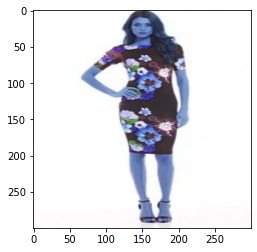

Geo_Print_Cutout_Dress


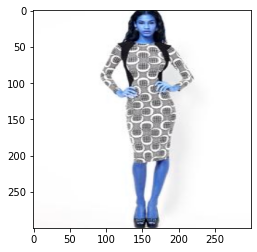

Marled_Knit_Joggers


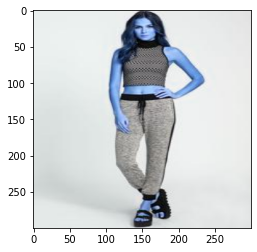

Mid-Rise_-_Distressed_Boyfriend_Jeans


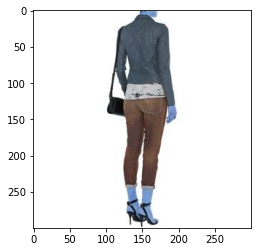

Butterfly_Sleeve_Sheath_Dress


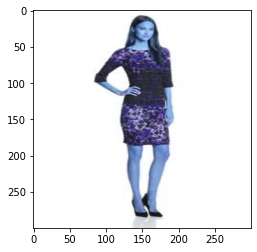

Original Image 4
Tulip-Back_Chiffon_Blazer


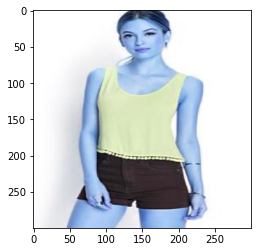

Belted_Pleat-Front_Shorts


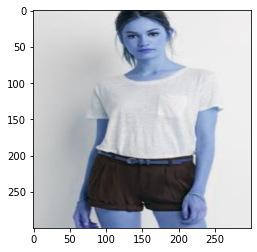

Ladder_Cutout_Halter_Tank


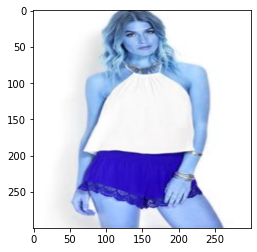

Classic_Knit_Tee


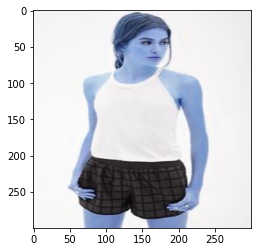

Flutter_Self-Tie_Blouse


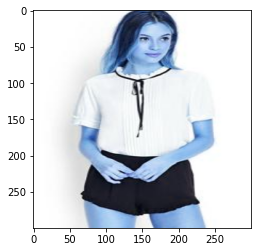

Abstract_Print_Shorts


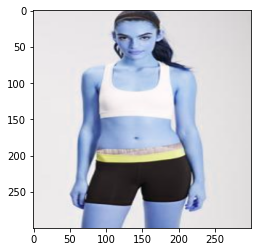

Original Image 100
Ikat_Print_Chiffon_Blouse


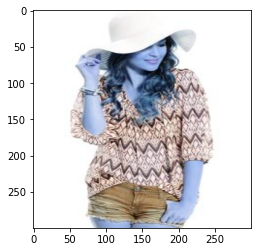

Baroque_Print_High-Neck_Romper


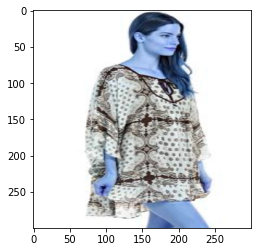

Tribal_Print_Scalloped_Romper


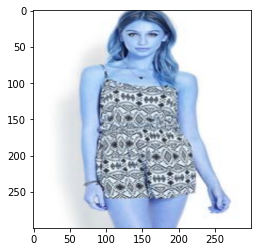

Striped_Geo_Pocket_Tank


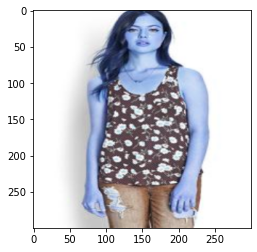

Nubby_Knit_Sweater


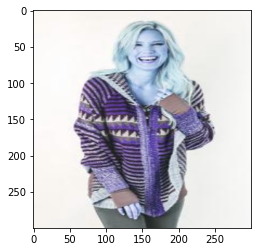

Buttoned-Front_Romper


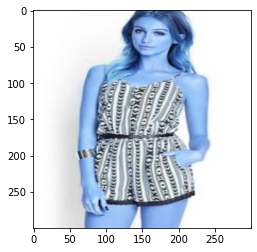

Original Image 101
Watercolor_Floral_Drawstring_Blouse


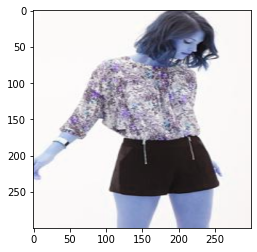

Crochet_Crepe_Woven_Shorts


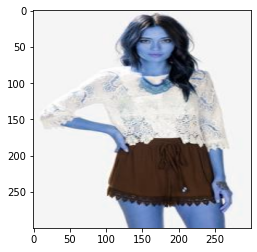

Southwestern-Patterned_Shorts


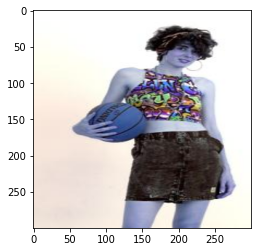

V-Back_Tee


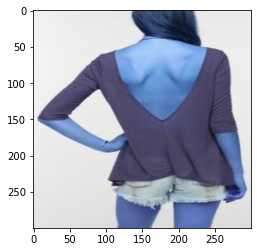

Collarless_Faux_Leather-Sleeve_Blazer


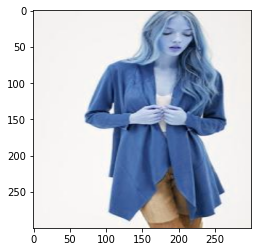

Cropped_Stripe_Sweater


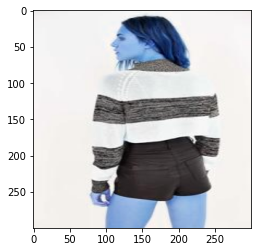

Original Image 150
Floral_Lace_Blouse


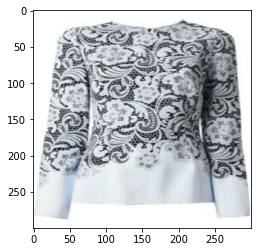

Floral_Print_Bomber_Jacket


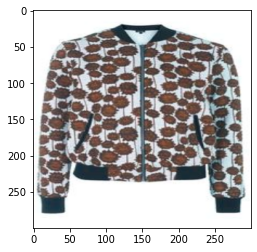

Diamond_Print_Shorts


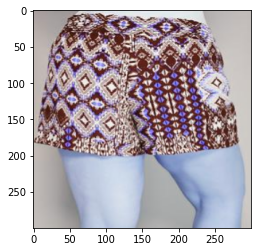

Colorblock_Woven_Running_Shorts


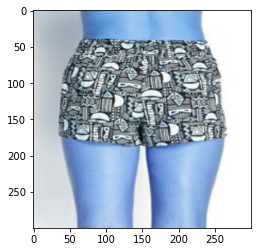

Diamond_Print_Shorts


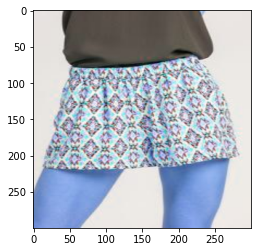

Crochet_Trim_Tribal_Print_Shorts


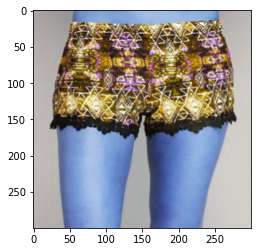

In [19]:
test_result_indices = test_data_neighbors[1]
imgIds = [9,4,100,101,150]
for i in imgIds:
  img_idx = testData.iloc[i]['index']
  print("Original Image", i)
  img_text = testData.iloc[i]["Image Paths"].split("/")[1]
  print(img_text)
  plt.imshow(images[img_idx])
  plt.show()
  for idx in test_result_indices[i]:
    train_idx = trainData.iloc[idx]['index']
    img_text = trainData.iloc[idx]["Image Paths"].split("/")[1]
    print(img_text)
    plt.imshow(images[train_idx])
    plt.show()

### VGG Model with Feature Extraction and Nearest Neighbors



img/Boxy_Surfboard_Tee/img_00000021.jpg
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPo

(4608,)

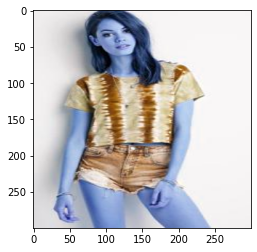

In [42]:
print(trainData.iloc[10001]['Image Paths'])
# plt.imshow(images[trainData.iloc[10000]['index']])

image = images[trainData.iloc[10001]['index']]
plt.imshow(image)
model2 = vgg(image.shape[0], image.shape[1])
image =  np.expand_dims(image, axis = 0) 
print(image.shape)
featureVector = getFeatureVector(model2, image)
featureVector.shape

In [43]:
def generateFeatures(model, data):
    labels = []
    features = []
    ids = []
    for index, row in data.iterrows():
        ids.append(index)
        image = images[data.iloc[index]['index']]
        image =  np.expand_dims(image, axis = 0) 
        label = row['Image Category']
        featureVector = getFeatureVector(model, image)
        features.append(featureVector)
        labels.append(label)

    return np.array(features), labels, ids

In [44]:
trainFeatures, trainLabels, trainIds = generateFeatures(model2, trainData)
testFeatures, testLabels, testIds = generateFeatures(model2, testData)

### Nearest neighbours without added features

In [45]:
from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=5, n_jobs=-1)
model_knn.fit(trainFeatures)
test_data_neighbors = model_knn.kneighbors(testFeatures)

### 5 Recommended Images for each 5 Random images for VGG

Original Image 9
Longline_Side-Slit_Blazer


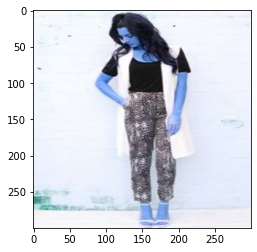

Acid_Wash_Denim_Skirt


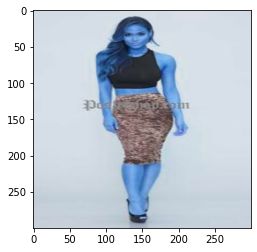

Tribal_Print_Jumpsuit


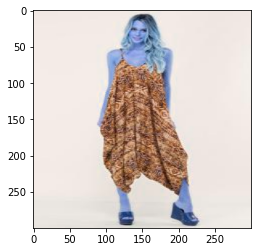

Boxy_Marled_Knit_Top


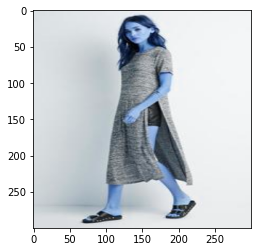

Go_Baroque_Trapeze_Dress


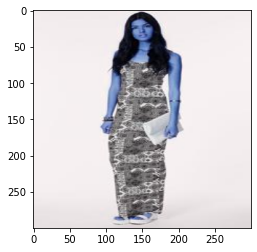

Metallic_Maxi_Dress


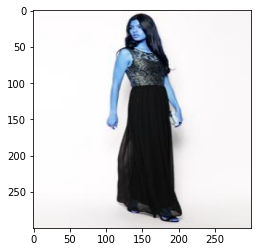

Original Image 4
Tulip-Back_Chiffon_Blazer


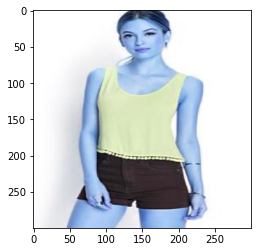

Dip-Dye_Tank


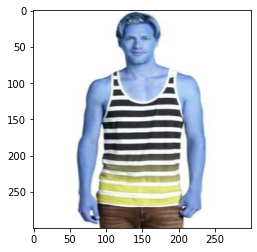

Favorite_Scoop_Neck_Tank


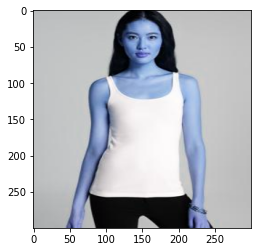

Gauze_Layered-Trim_Blouse


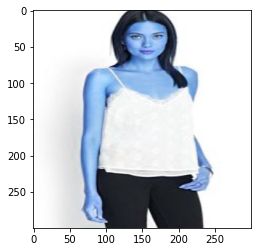

Floral_Lace_Tank


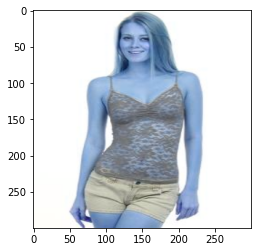

Lace-Paneled_Pintucked_Blouse


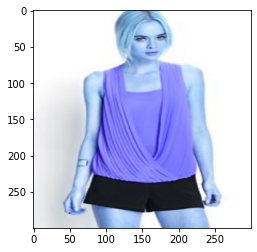

Original Image 100
Ikat_Print_Chiffon_Blouse


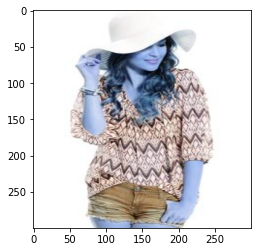

Baroque_Print_Crop_Top


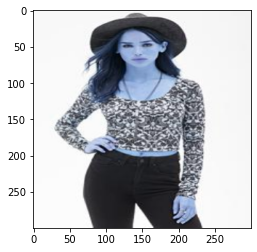

Abstract_Dotted_Dress


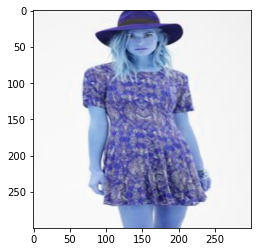

Floral_Paisley_Shift_Dress


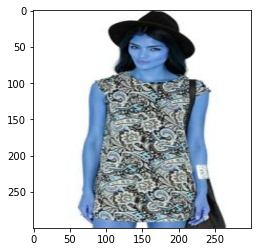

Lace-Paneled_Lattice-Back_Blouse


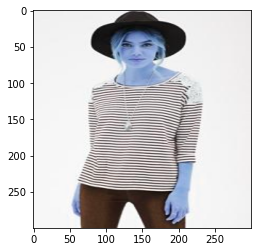

Split-Back_Pleated_Blouse


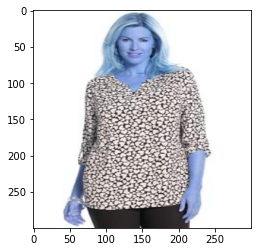

Original Image 101
Watercolor_Floral_Drawstring_Blouse


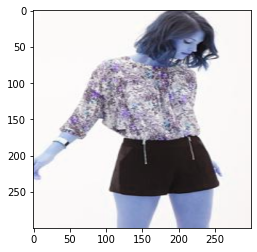

Be_Seen_Open-Knit_Sweater


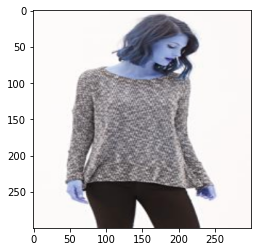

Belted_Paisley_Print_Dress


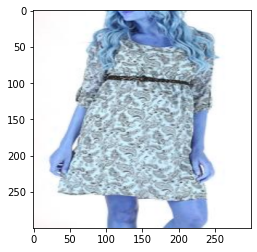

Open-Front_Pointelle_Cardigan


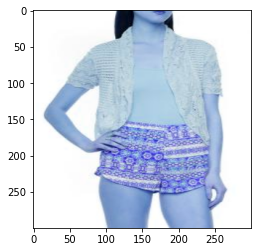

Southwestern_Print_A-Line_Dress


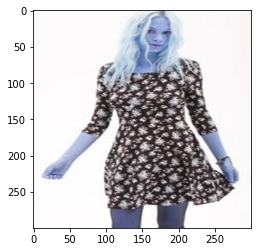

Crochet_Crepe_Woven_Shorts


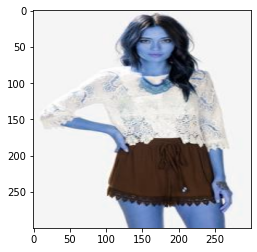

Original Image 150
Floral_Lace_Blouse


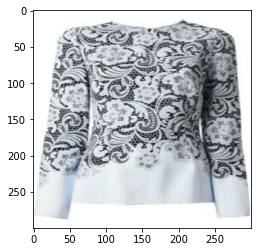

Embellished_Tile_Print_Kimono


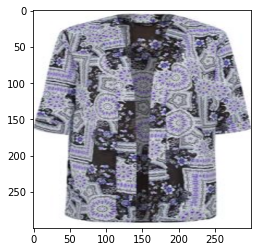

Bead-Embellished_Top


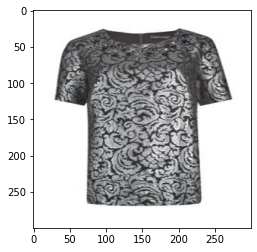

Lace-Paneled_Sweater


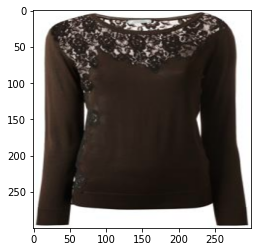

Boxy_Floral_Print_Tee


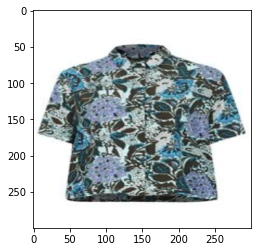

Faux_Fur_Cheetah_Coat


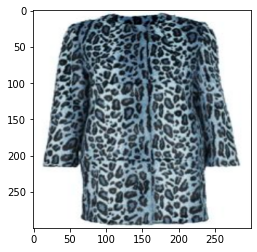

In [46]:
test_result_indices = test_data_neighbors[1]
imgIds = [9,4,100,101,150]
for i in imgIds:
  img_idx = testData.iloc[i]['index']
  print("Original Image", i)
  img_text = testData.iloc[i]["Image Paths"].split("/")[1]
  print(img_text)
  plt.imshow(images[img_idx])
  plt.show()
  for idx in test_result_indices[i]:
    train_idx = trainData.iloc[idx]['index']
    img_text = trainData.iloc[idx]["Image Paths"].split("/")[1]
    print(img_text)
    plt.imshow(images[train_idx])
    plt.show()

In [47]:
saveInPickle([trainFeatures, trainLabels , trainIds], "vgg_train")
saveInPickle([testFeatures, testLabels, testIds], "vgg_test")

### Resnet Model with Feature Extraction and Nearest Neighbors



img/V-Back_Tee/img_00000055.jpg
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 306, 306, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 150, 150, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                            

(20480,)

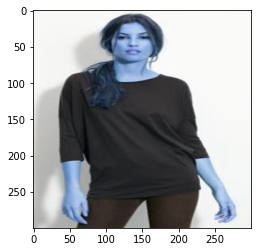

In [28]:
print(trainData.iloc[10002]['Image Paths'])
# plt.imshow(images[trainData.iloc[10000]['index']])

image = images[trainData.iloc[10002]['index']]
plt.imshow(image)
model3 = resNet(image.shape[0], image.shape[1])
image =  np.expand_dims(image, axis = 0) 
print(image.shape)
featureVector = getFeatureVector(model3, image)
featureVector.shape

In [29]:
def generateFeatures(model, data):
    labels = []
    features = []
    ids = []
    for index, row in data.iterrows():
        ids.append(index)
        image = images[data.iloc[index]['index']]
        image =  np.expand_dims(image, axis = 0) 
        label = row['Image Category']
        featureVector = getFeatureVector(model, image)
        features.append(featureVector)
        labels.append(label)

    return np.array(features), labels, ids

In [30]:
trainFeatures, trainLabels, trainIds = generateFeatures(model3, trainData)
testFeatures, testLabels, testIds = generateFeatures(model3, testData)

### Nearest neighbours without added features

In [31]:
from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=5, n_jobs=-1)
model_knn.fit(trainFeatures)
test_data_neighbors = model_knn.kneighbors(testFeatures)

### 5 Recommended Images for each 5 Random images for Resnet

Original Image 9
Longline_Side-Slit_Blazer


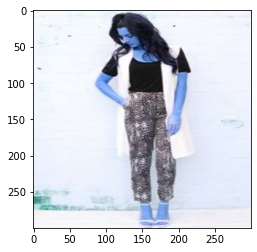

Leopard_Print_Joggers


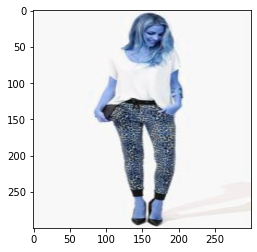

Lace_Insert_Bodycon_Dress


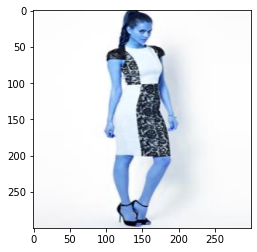

Woven_Suit_Joggers


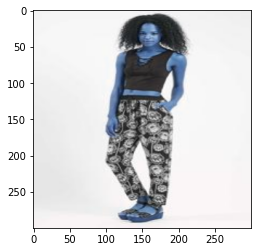

Leaf_Print_Joggers


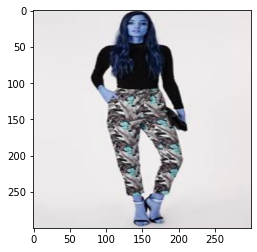

Paisley_Maxi_Cami_Dress


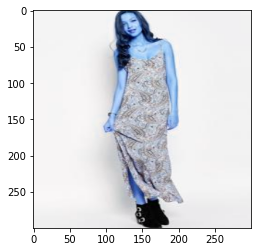

Original Image 4
Tulip-Back_Chiffon_Blazer


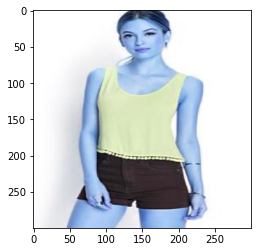

Heathered_Stripe-Pocket_Tank


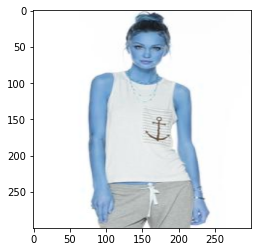

Mesh_Panel_Tank


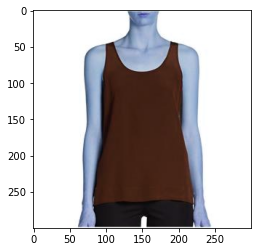

Cuffed-Sleeve_Linen_Tee


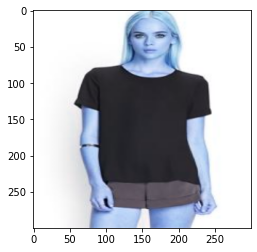

Lace-Paneled_Pintucked_Blouse


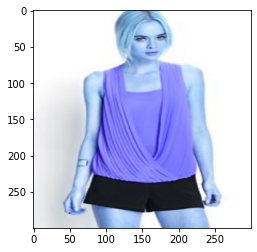

Distressed_Slub_Knit_Tank


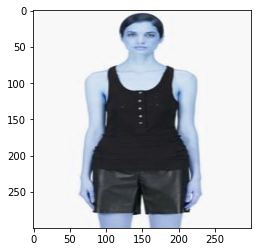

Original Image 100
Ikat_Print_Chiffon_Blouse


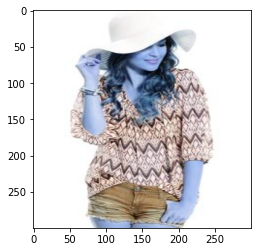

Rad_Graphic_Tee


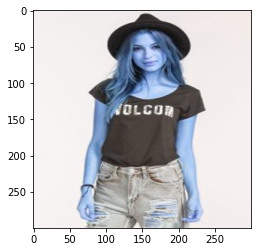

Led_Zeppelin_Graphic_Tee


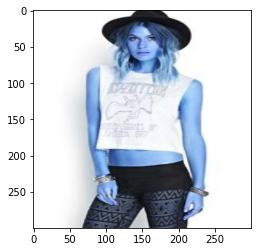

Textured_Zigzag_Bodycon_Dress


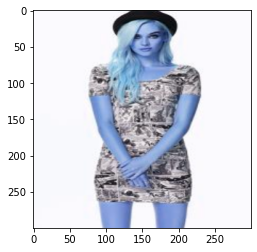

Floral_Foliage_Cami_Dress


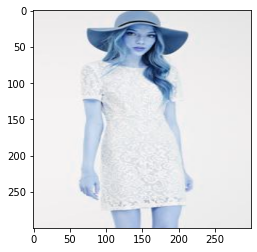

Marled_Knit_Sweater


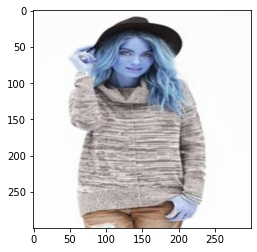

Original Image 101
Watercolor_Floral_Drawstring_Blouse


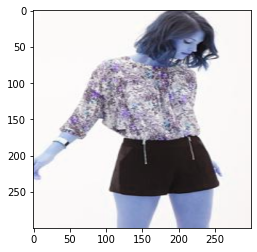

Be_Seen_Open-Knit_Sweater


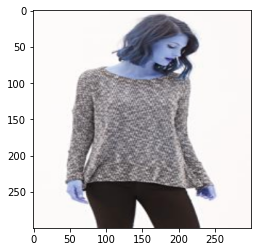

Southwestern_Print_A-Line_Dress


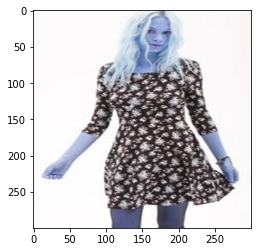

Belted_Paisley_Print_Dress


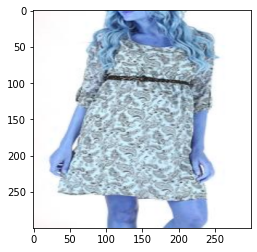

Faux_Leather_Skater_Dress


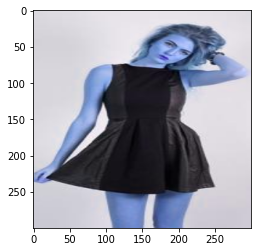

Barbie_Kiss_Hoodie


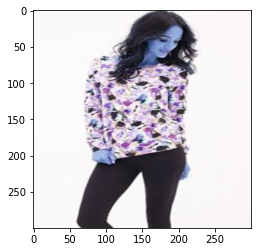

Original Image 150
Floral_Lace_Blouse


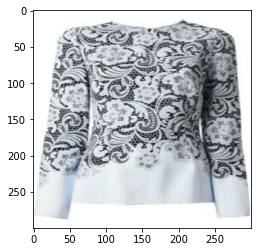

Fox_Print_Tee


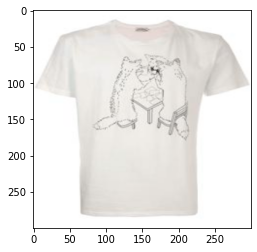

Metallic_Brocade_Mini_Skirt


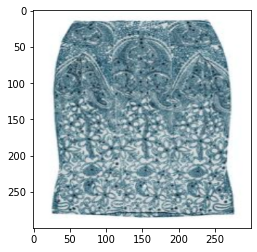

Embroidered_Mesh_Bomber_Jacket


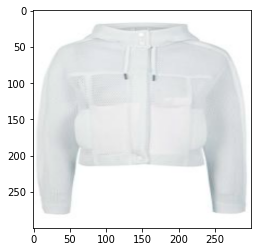

Ruffled_Trim_Sweater


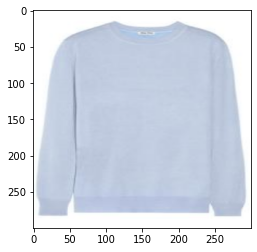

Leaf_Print_Blouse


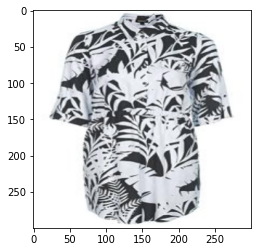

In [32]:
test_result_indices = test_data_neighbors[1]
imgIds = [9,4,100,101,150]
for i in imgIds:
  img_idx = testData.iloc[i]['index']
  print("Original Image", i)
  img_text = testData.iloc[i]["Image Paths"].split("/")[1]
  print(img_text)
  plt.imshow(images[img_idx])
  plt.show()
  for idx in test_result_indices[i]:
    train_idx = trainData.iloc[idx]['index']
    img_text = trainData.iloc[idx]["Image Paths"].split("/")[1]
    print(img_text)
    plt.imshow(images[train_idx])
    plt.show()

In [39]:
def loadFromPickle(pickleFile):
	file = open(pickleFile,'rb')
	pickleData = pickle.load(file)
	file.close()
	return pickleData

def saveInPickle(data, pickleFile):
	file = open(pickleFile,"wb")
	pickle.dump(data,file)
	file.close()
        

In [40]:
saveInPickle([trainFeatures, trainLabels , trainIds], "resnet_train")
saveInPickle([testFeatures, testLabels, testIds], "resnet_test")

### Resnet Model and VGG Model Ensemble as Feature Extraction and Nearest Neighbors

In [49]:
def generateEnsembleFeatures(Trainfeatures1, TestFeatures1, Trainfeatures2, TestFeatures2, weight1, weight2):
    len1 = Trainfeatures1.shape[1]
    len2 = Trainfeatures2.shape[1]
    print(len1, len2)
    classEncoder = preprocessing.LabelEncoder()
    classEncoder.fit(trainLabels)
    labels = classEncoder.transform(trainLabels)
    if(len1 > len2):
        xNew = SelectKBest(k=len2).fit(Trainfeatures1, labels)
        Trainfeatures1 = xNew.transform(Trainfeatures1)
        TestFeatures1 = xNew.transform(TestFeatures1)
    else:
        xNew = SelectKBest(k=len1).fit(Trainfeatures2, labels)
        Trainfeatures2 = xNew.transform(Trainfeatures2)
        TestFeatures2 = xNew.transform(TestFeatures2)

    combinedTrainFeatures = Trainfeatures1*weight1 + Trainfeatures2*weight2
    combinedTestFeatures = TestFeatures1*weight1 + TestFeatures2*weight2
    return combinedTrainFeatures, combinedTestFeatures

In [50]:
def loadTrainFeatures(modelName):
    trainSet = loadFromPickle(modelName+ "_train")
    return trainSet[0], trainSet[1], trainSet[2]

def loadTestFeatures(modelName):
    testSet = loadFromPickle(modelName+ "_test")
    return testSet[0], testSet[1], testSet[2]

### Setting the Ensemble model with weights

In [52]:
trainFeatures1, trainLabels , trainIds = loadTrainFeatures("resnet")
testFeatures1, testLabels , testIds = loadTestFeatures("resnet")

trainFeatures2, trainLabels , trainIds = loadTrainFeatures("vgg")
testFeatures2, testLabels , testIds = loadTestFeatures("vgg")
print(testFeatures1.shape, testFeatures2.shape)
trainFeatures, testFeatures = generateEnsembleFeatures(trainFeatures1, testFeatures1, trainFeatures2, testFeatures2,0.4,0.6)


(2820, 20480) (2820, 4608)
20480 4608


### Nearest neighbours without added features

In [53]:
from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=5, n_jobs=-1)
model_knn.fit(trainFeatures)
test_data_neighbors = model_knn.kneighbors(testFeatures)

### 5 Recommended Images for each 5 Random images for Ensemble Model

Original Image 9
Longline_Side-Slit_Blazer


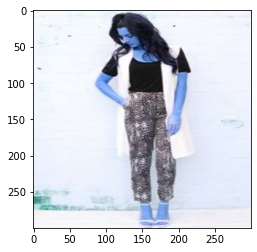

Acid_Wash_Denim_Skirt


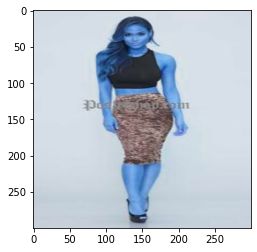

Tribal_Print_Jumpsuit


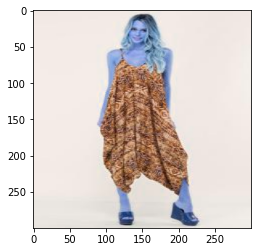

Ribbed_Knit_Trapeze_Dress


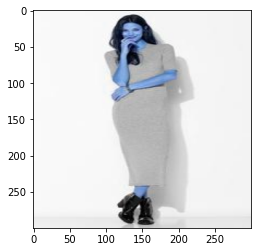

Boxy_Marled_Knit_Top


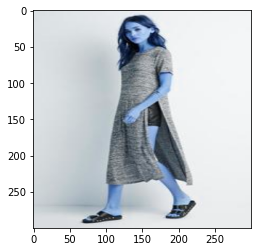

Diamond_Print_Bow_Shorts


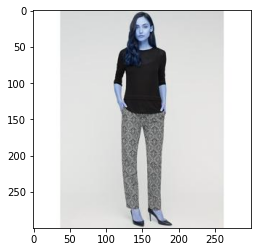

Original Image 4
Tulip-Back_Chiffon_Blazer


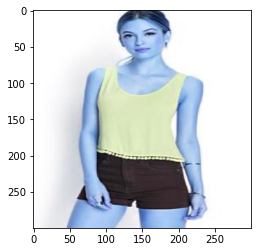

Dip-Dye_Tank


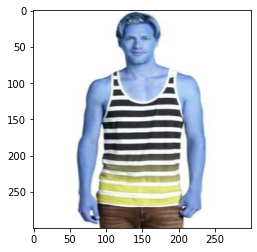

Favorite_Scoop_Neck_Tank


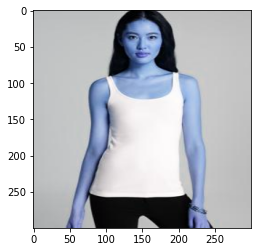

Floral_Lace_Tank


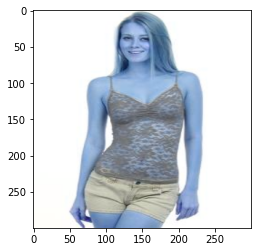

Gauze_Layered-Trim_Blouse


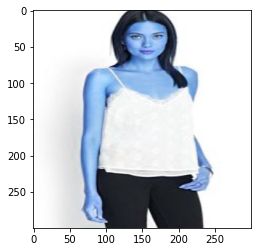

Lace-Paneled_Pintucked_Blouse


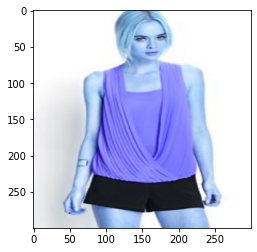

Original Image 100
Ikat_Print_Chiffon_Blouse


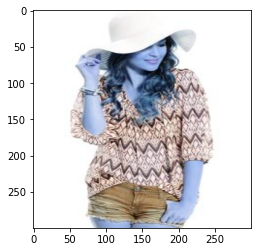

Baroque_Print_Crop_Top


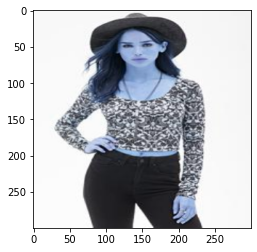

Floral_Paisley_Shift_Dress


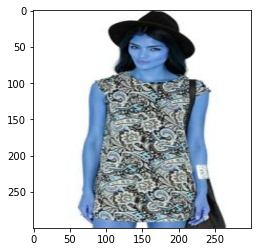

Lace-Paneled_Lattice-Back_Blouse


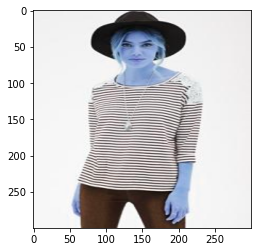

Striped_Marled_Knit_Cardigan


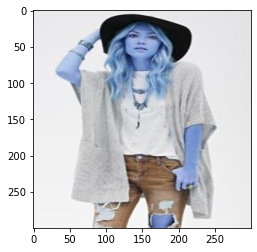

Abstract_Dotted_Dress


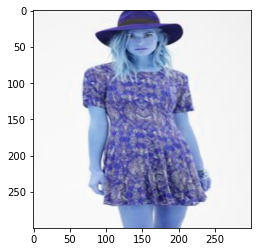

Original Image 101
Watercolor_Floral_Drawstring_Blouse


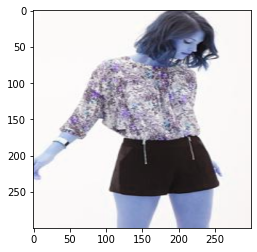

Be_Seen_Open-Knit_Sweater


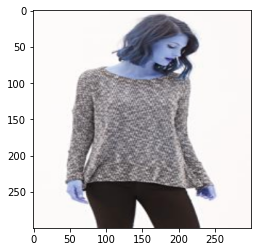

Southwestern_Print_A-Line_Dress


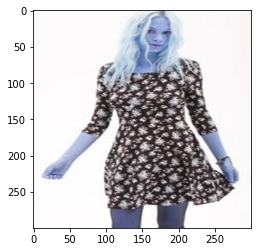

Belted_Paisley_Print_Dress


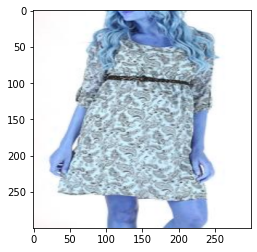

Open-Front_Pointelle_Cardigan


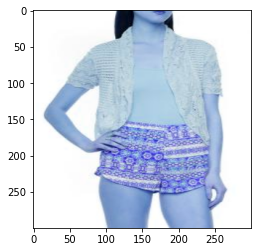

Crochet_Crepe_Woven_Shorts


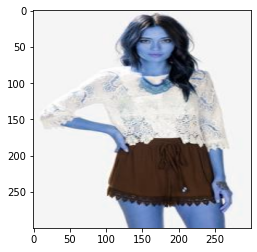

Original Image 150
Floral_Lace_Blouse


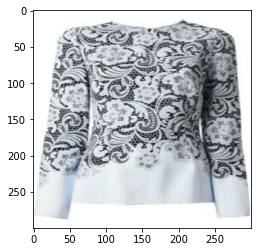

Embellished_Tile_Print_Kimono


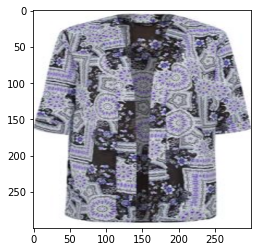

Lace-Paneled_Sweater


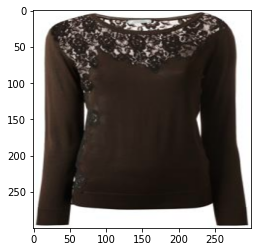

Bead-Embellished_Top


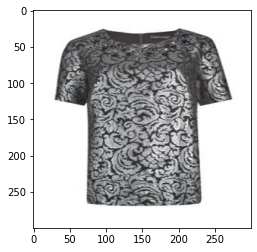

Boxy_Floral_Print_Tee


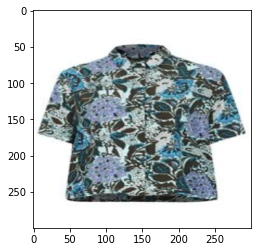

Faux_Fur_Cheetah_Coat


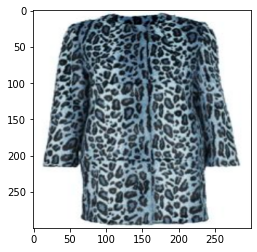

In [54]:
test_result_indices = test_data_neighbors[1]
imgIds = [9,4,100,101,150]
for i in imgIds:
  img_idx = testData.iloc[i]['index']
  print("Original Image", i)
  img_text = testData.iloc[i]["Image Paths"].split("/")[1]
  print(img_text)
  plt.imshow(images[img_idx])
  plt.show()
  for idx in test_result_indices[i]:
    train_idx = trainData.iloc[idx]['index']
    img_text = trainData.iloc[idx]["Image Paths"].split("/")[1]
    print(img_text)
    plt.imshow(images[train_idx])
    plt.show()